In [100]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import seaborn as sns
from skimage.morphology import closing, square, opening, dilation


matplotlib.rcParams.update({'font.size': 16})


In [2]:
path = "/Users/german/Documents/MASTER/Courses/M6 - Video Analysis/Project/W1/results"
img45_name = "LKflow_000045_10.png"
img157_name = "LKflow_000157_10.png"
GT_img45_name = "000045_10.png"
GT_img157_name = "000157_10.png"
RGB_img45_name = "color/000045_10.png"
RGB_img157_name = "color/000157_10.png"

In [3]:
img45 = cv2.cvtColor(cv2.imread(os.path.join(path, img45_name), cv2.IMREAD_UNCHANGED).astype(np.uint16), cv2.COLOR_BGR2RGB)
img157 = cv2.cvtColor(cv2.imread(os.path.join(path, img157_name), cv2.IMREAD_UNCHANGED).astype(np.uint16), cv2.COLOR_BGR2RGB)
img45_GT = cv2.cvtColor(cv2.imread(os.path.join(path, GT_img45_name), cv2.IMREAD_UNCHANGED).astype(np.uint16), cv2.COLOR_BGR2RGB)
img157_GT = cv2.cvtColor(cv2.imread(os.path.join(path, GT_img157_name), cv2.IMREAD_UNCHANGED).astype(np.uint16), cv2.COLOR_BGR2RGB)
img45_RGB = cv2.cvtColor(cv2.imread(os.path.join(path, RGB_img45_name), cv2.IMREAD_UNCHANGED).astype(np.uint16), cv2.COLOR_BGR2RGB)
img157_RGB = cv2.cvtColor(cv2.imread(os.path.join(path, RGB_img157_name), cv2.IMREAD_UNCHANGED).astype(np.uint16), cv2.COLOR_BGR2RGB)

> IMG 45 <

MSEN = 10.63 - PEPN = 78.56%


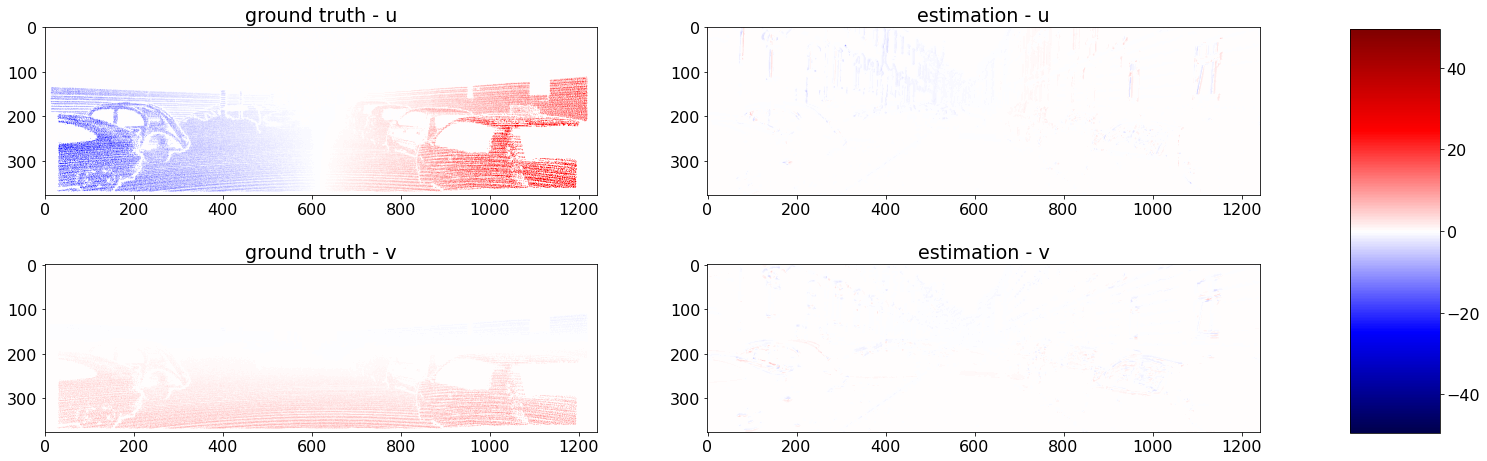

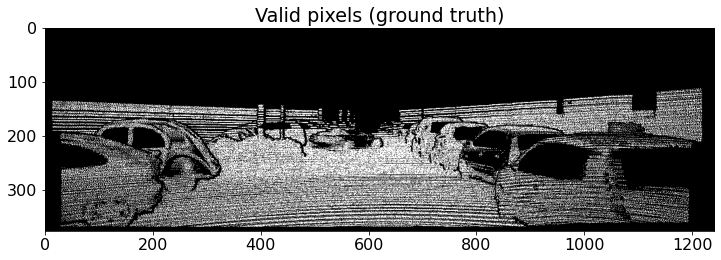

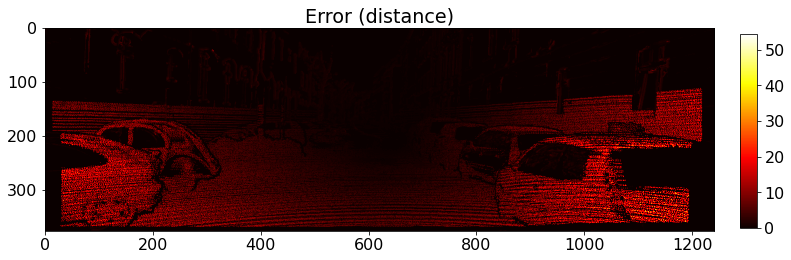

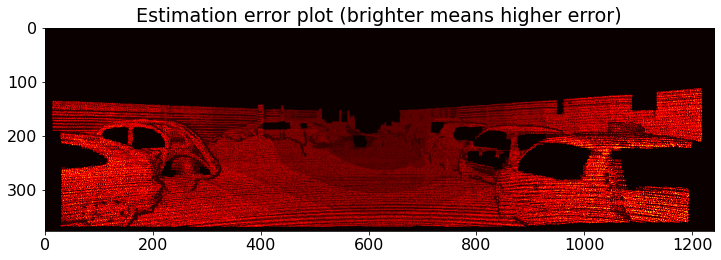


 >>> Quantitative analysis <<<


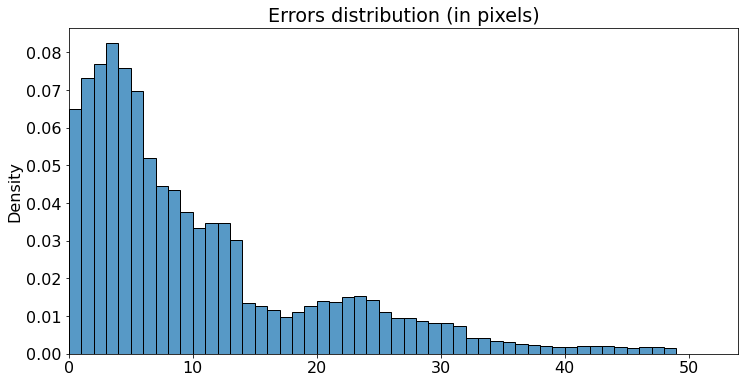

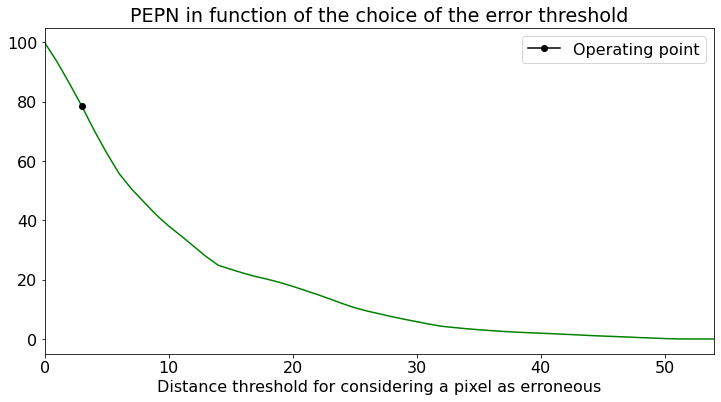

In [188]:
def transform_annotation(img):
    flow_u = (img[:,:,0].astype(float) - 2. ** 15) / 64.0
    flow_v = (img[:,:,1].astype(float) - 2. ** 15) / 64.0
    valid  = img[:,:,2].astype(bool)
    return flow_u, flow_v, valid

def get_metrics(GT_u, GT_v, u, v, mask, th):
    # we compute the motion vectors between GT and inferred
    motion_vectors = np.square(GT_u - u) + np.square(GT_v - v)
    motion_vectors_dist = np.sqrt(motion_vectors)

    # we compute metrics considering only non-occluded pixels (GT_valid)
    msen = np.mean(np.sqrt(motion_vectors)[mask != 0])
    pepn = 100 * (motion_vectors_dist[mask != 0] > th).sum() / (mask != 0).sum()  # erroneous / total
    
    return motion_vectors_dist, msen, pepn


def run_task3(img, gt_img, th=3):
    assert (gt_img.shape == img.shape)
    
    # we transform the annotations as explained in the documentation
    GT_u, GT_v, GT_valid = transform_annotation(gt_img)
    u, v, _ = transform_annotation(img)
    
    motion_vectors_dist, msen, pepn = get_metrics(GT_u, GT_v, u, v, GT_valid, th)
    print(f"\nMSEN = {msen:.2f} - PEPN = {pepn:.2f}%")
    
    max_val = max(abs(max(GT_u.max(), GT_v.max(), u.max(), v.max())), 
                  abs(min(GT_u.min(), GT_v.min(), u.min(), v.min())))
    
    cmap = "seismic"
    fig, ax = plt.subplots(2,2, figsize=(25,8))
    ax[0][0].set_title("ground truth - u")
    im = ax[0][0].imshow(GT_u, cmap=cmap, vmin=-max_val, vmax=max_val)
    #plt.colorbar(im, ax=ax[0,0])
    
    ax[1][0].set_title("ground truth - v")
    im = ax[1][0].imshow(GT_v, cmap=cmap, vmin=-max_val, vmax=max_val)
    #plt.colorbar(im, ax=ax[1,0])
    
    ax[0][1].set_title("estimation - u")
    im = ax[0][1].imshow(u, cmap=cmap, vmin=-max_val, vmax=max_val)
    #plt.colorbar(im, ax=ax[0,1])
    
    ax[1][1].set_title("estimation - v")
    im = ax[1][1].imshow(v, cmap=cmap, vmin=-max_val, vmax=max_val)
    #plt.colorbar(im, ax=ax[1,1])
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
    
    cmap = "viridis"
    
    plt.figure(figsize=(12,9))
    plt.title("Valid pixels (ground truth)")
    plt.imshow(GT_valid, cmap='gray')
    plt.show()
    
    fig = plt.figure(figsize=(12,9))
    rge = motion_vectors_dist.max() - motion_vectors_dist.min()
    plt.title("Error (distance)")
    im = plt.imshow(motion_vectors_dist, cmap="hot")
    cbar_ax = fig.add_axes([0.93, 0.35, 0.02, 0.3])
    fig.colorbar(im, cax = cbar_ax)
    plt.show()
    
    plt.figure(figsize=(12,9))
    plt.title("Estimation error plot (brighter means higher error)")
    mvd = motion_vectors_dist**(0.75) # to be finer in the low range of errors
    rge = mvd.max() - mvd.min()
    img = np.ceil(1 + 15 * (mvd - np.min(mvd)) / rge)
    img[opening(GT_valid == 0, square(10))] = 0
    im = plt.imshow(img, cmap='hot')
    plt.show()
    
    print("\n >>> Quantitative analysis <<<")
    
    ths = list(range(55)) #int(motion_vectors_dist[GT_valid != 0].max())))
    plt.figure(figsize=(12,6))
    plt.title("Errors distribution (in pixels)")
    sns.histplot(motion_vectors_dist[GT_valid != 0], stat="density", bins=range(50))
    plt.xlim(0, max(ths))
    plt.show()
    
    plt.figure(figsize=(12,6))
    pepns = []
    for th in ths:
        motion_vectors_dist, msen, pepn = get_metrics(GT_u, GT_v, u, v, GT_valid, th)
        pepns.append(pepn)
    plt.plot(ths, pepns, color="green")
    plt.plot((3, ), (pepns[3]), marker="o", color="black", label="Operating point")
    plt.xlim(0, max(ths))
    plt.legend()
    plt.title("PEPN in function of the choice of the error threshold")
    plt.xlabel("Distance threshold for considering a pixel as erroneous")
    
    
print("> IMG 45 <")
run_task3(img45, img45_GT)

> IMG 157 <

MSEN = 2.75 - PEPN = 34.05%


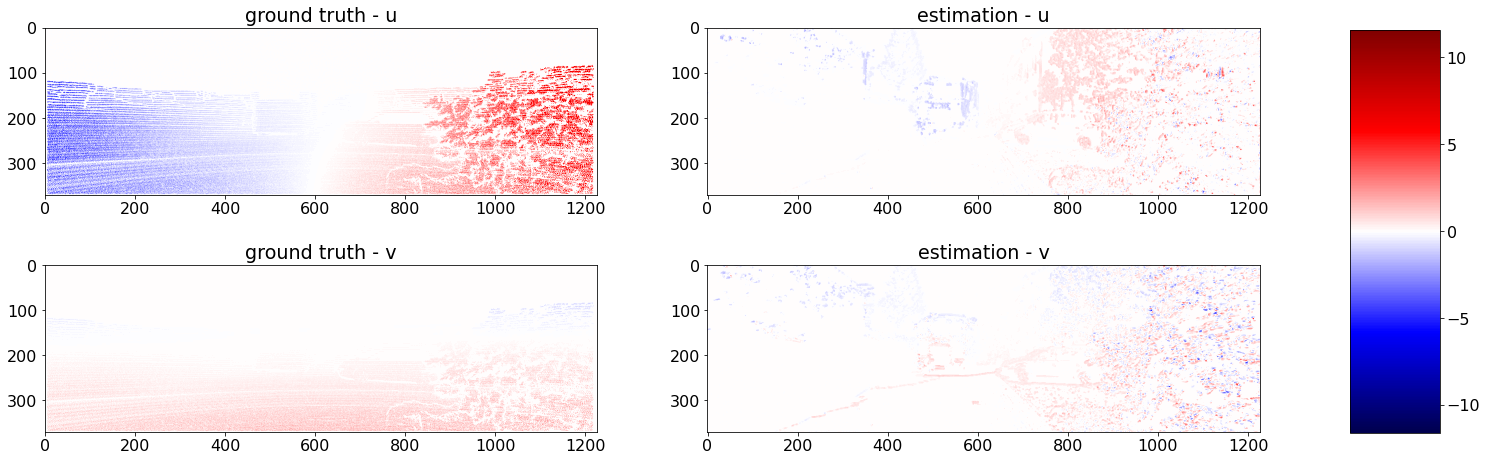

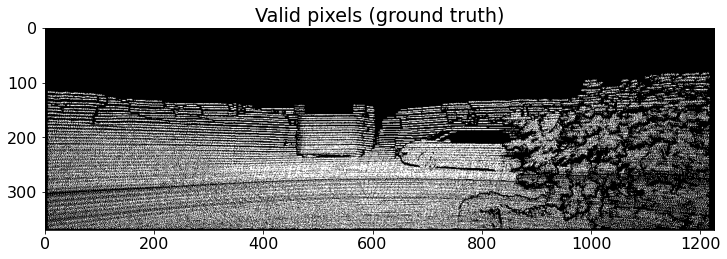

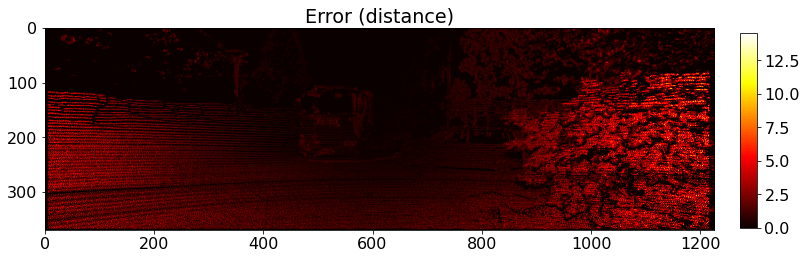

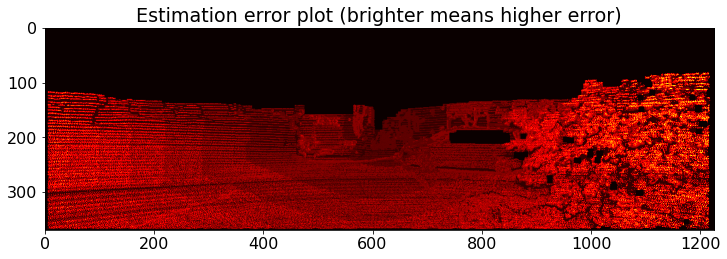


 >>> Quantitative analysis <<<


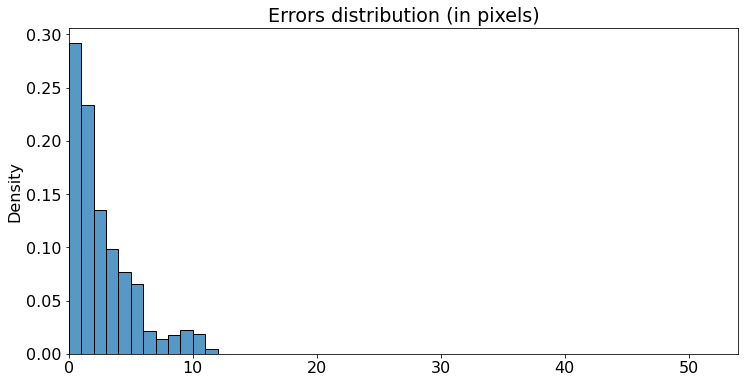

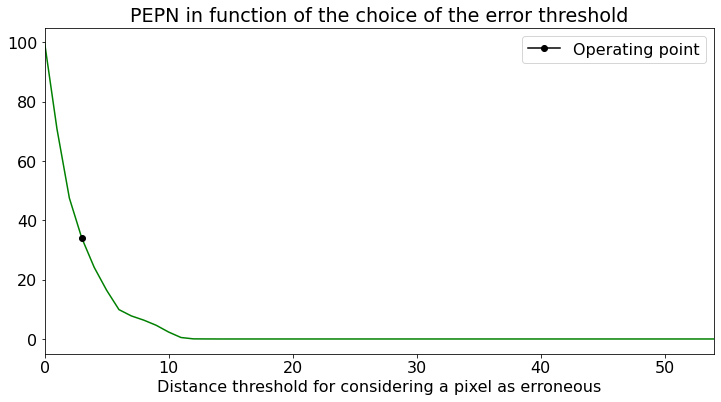

In [189]:

print("> IMG 157 <")
run_task3(img157, img157_GT)